In [ ]:
# ✅
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split


In [ ]:
# ✅
import torch
from torch.utils.data import Dataset
import torch.nn as nn
import torch.optim as optim

print("CUDA available:", torch.cuda.is_available())   # True = NVIDIA GPU usable
print("MPS available:", torch.backends.mps.is_available())  # True = Apple GPU usable (M1/M2/M3)

device = (
    "cuda" if torch.cuda.is_available() else      # NVIDIA GPU
    "mps" if torch.backends.mps.is_available() else  # Apple M1/M2/M3 GPU
    "cpu"  # fallback to CPU
)

print("Using device:", device)

CUDA available: False
MPS available: True
Using device: mps


In [ ]:
# ✅
import os

data_dir = "data"           # folder containing class subfolders
class_names = os.listdir(data_dir)  # automatically gets ["clouds","desert","green","water"]
print("Classes:", class_names)


Classes: ['cloudy', 'water', 'green_area', 'desert']


In [ ]:
# ✅
def path_data(root_dir):
    # class_names is already defined globally from data_subdir, so we can reuse it.
    class_to_idx = {cls_name: i for i, cls_name in enumerate(class_names)}

    img_paths = []
    labels = []

    for cls_name in class_names:
        cls_dir = os.path.join(root_dir, cls_name)
        for fname in os.listdir(cls_dir):
            img_paths.append(os.path.join(cls_dir, fname))
            labels.append(class_to_idx[cls_name])

    return img_paths, labels, class_names, class_to_idx

# Pass data_subdir instead of path to path_data
img_paths, labels, class_names, class_to_idx = path_data(data_dir)

print("Classes:", class_names)
print("Image count:", len(img_paths))

Classes: ['cloudy', 'water', 'green_area', 'desert']
Image count: 5631


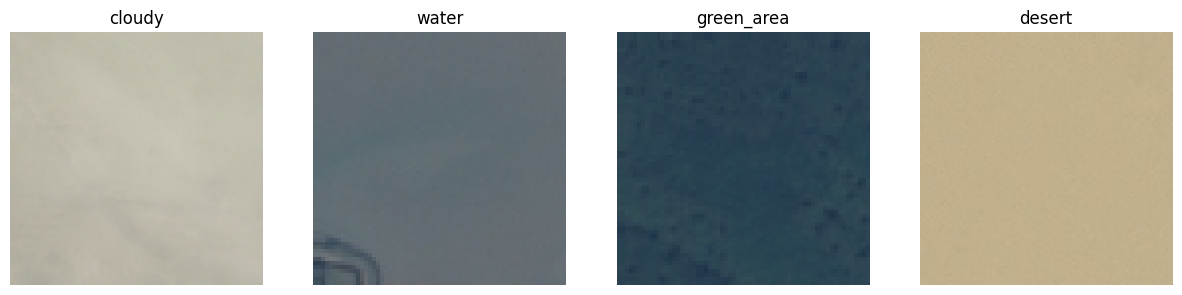

In [ ]:
# ✅
def show_one_image_per_class(data_dir, class_names):
    plt.figure(figsize=(15, 5))
    shown_classes = set()

    for i, cls in enumerate(class_names):
        cls_folder = os.path.join(data_dir, cls)
        # Only include real image files
        images = [f for f in os.listdir(cls_folder) if f.lower().endswith(('.png','.jpg','.jpeg'))]
        if not images:
            print(f"No images found for class: {cls}")
            continue
        # Pick one random image
        img_path = os.path.join(cls_folder, random.choice(images))
        img = Image.open(img_path).convert("RGB")

        plt.subplot(1, len(class_names), i+1)
        plt.imshow(img)
        plt.title(cls)
        plt.axis('off')
        shown_classes.add(cls)

    plt.show()



show_one_image_per_class(data_dir, class_names)

In [ ]:
# ✅
TrainVal_paths, Test_paths, TrainVal_labels, Test_labels = train_test_split(
    img_paths, labels, test_size=0.1, random_state=42, stratify=labels
)

Train_paths, Val_paths, Train_labels, Val_labels = train_test_split(
    TrainVal_paths, TrainVal_labels, test_size=0.2, random_state=42, stratify=TrainVal_labels
)

print("Train images count:", len(Train_paths))
print("Validation images count:", len(Val_paths))
print("Test images count:", len(Test_paths))

Train images count: 4053
Validation images count: 1014
Test images count: 564


In [ ]:
# ✅
class Satellite_dataset(Dataset):
    def __init__(self, img_paths, labels, transform=None):
        self.img_paths = img_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img = Image.open(self.img_paths[idx]).convert("RGB")
        label = self.labels[idx]
        if self.transform:
            img = self.transform(img)
        return img, label

In [ ]:
# ✅
import torchvision.transforms as transforms

Transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
Train_D = Satellite_dataset(Train_paths, Train_labels, transform=Transform)
Val_D = Satellite_dataset(Val_paths, Val_labels, transform=Transform)
Test_D = Satellite_dataset(Test_paths, Test_labels, transform=Transform)

In [ ]:
# ✅
from torch.utils.data import DataLoader

Train_B = DataLoader(Train_D, batch_size=32, shuffle=True)
Val_B = DataLoader(Val_D, batch_size=32, shuffle=False)
Test_B = DataLoader(Test_D, batch_size=32, shuffle=False)

In [ ]:
# actuall inception module a bit overkill
# too slow
class InceptionModule(nn.Module):  
    def __init__(self, in_channels, out1x1, out3x3reduce, out3x3,
                 out5x5reduce, out5x5, out_pool):
        super().__init__()

        # 1x1 conv branch
        self.branch1 = nn.Conv2d(in_channels, out1x1, kernel_size=1)

        # 1x1 -> 3x3 conv branch
        self.branch2 = nn.Sequential(
            nn.Conv2d(in_channels, out3x3reduce, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out3x3reduce, out3x3, kernel_size=3, padding=1)
        )

        # 1x1 -> 5x5 conv branch too much to compute 
        self.branch3 = nn.Sequential(
            nn.Conv2d(in_channels, out5x5reduce, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out5x5reduce, out5x5, kernel_size=5, padding=2)
        )

        # Pooling branch
        self.branch4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            nn.Conv2d(in_channels, out_pool, kernel_size=1)
        )

        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        b1 = self.branch1(x)
        b2 = self.branch2(x)
        b3 = self.branch3(x)
        b4 = self.branch4(x)
        out = torch.cat([b1, b2, b3, b4], dim=1)
        out = self.relu(out)
        return out



In [ ]:
# ✅
class InceptionModule(nn.Module):
    def __init__(self, in_channels, out1x1, out3x3reduce, out3x3,
                 out5x5reduce, out5x5, out_pool):
        super().__init__()

        # 1x1 branch
        self.branch1 = nn.Sequential(
            nn.Conv2d(in_channels, out1x1, kernel_size=1, bias=False),
            nn.BatchNorm2d(out1x1),
            nn.ReLU(inplace=True)
        )

        # 1x1 -> 3x3 branch
        self.branch2 = nn.Sequential(
            nn.Conv2d(in_channels, out3x3reduce, kernel_size=1, bias=False),
            nn.BatchNorm2d(out3x3reduce),
            nn.ReLU(inplace=True),

            nn.Conv2d(out3x3reduce, out3x3, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out3x3),
            nn.ReLU(inplace=True)
        )

        # 1x1 -> 3x3 -> 3x3 (replaces 5x5)
        self.branch3 = nn.Sequential(
            nn.Conv2d(in_channels, out5x5reduce, kernel_size=1, bias=False),
            nn.BatchNorm2d(out5x5reduce),
            nn.ReLU(inplace=True),

            nn.Conv2d(out5x5reduce, out5x5, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out5x5),
            nn.ReLU(inplace=True),

            nn.Conv2d(out5x5, out5x5, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out5x5),
            nn.ReLU(inplace=True)
        )

        # Pool branch
        self.branch4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            nn.Conv2d(in_channels, out_pool, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_pool),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return torch.cat([
            self.branch1(x),
            self.branch2(x),
            self.branch3(x),
            self.branch4(x)
        ], dim=1)


In [ ]:
# ✅
# nadded batchnorem 3x3 conv insted of 5x5 prevent eraly downsampling throws away detail 
#  Test Accuracy: 0.9043 simpilisity is best ? Epoch [10/10],Training Loss: 0.1423, Validation Accuracy: 0.9773
class CustomInception(nn.Module):
    def __init__(self, num_classes=4):  
        super().__init__()

        self.stem = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),

            nn.Conv2d(32, 32, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),

            nn.Conv2d(32, 64, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            nn.MaxPool2d(3, stride=2, padding=1),

            nn.Conv2d(64, 96, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(96),
            nn.ReLU(inplace=True),

            nn.Conv2d(96, 192, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(192),
            nn.ReLU(inplace=True),

            nn.MaxPool2d(3, stride=2, padding=1),
        )

        self.incep3a = InceptionModule(192, 64, 96, 128, 16, 32, 32)
        self.incep3b = InceptionModule(256, 128, 128, 192, 32, 96, 64)
        self.pool = nn.MaxPool2d(3, stride=2, padding=1)

        self.incep4a = InceptionModule(480, 192, 96, 208, 16, 48, 64)

        self.avgpool = nn.AdaptiveAvgPool2d((4, 4))

        self.fc = nn.Sequential(
            nn.Linear(512 * 4 * 4, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.stem(x)
        x = self.incep3a(x)
        x = self.incep3b(x)
        x = self.pool(x)
        x = self.incep4a(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        return self.fc(x)


In [ ]:
class CustomInception(nn.Module): # not the best Training Loss: 0.7302, Validation Accuracy: 0.5247
    def __init__(self, num_classes=4):
        super().__init__()

        # early downsampling not best 
        self.stem = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, stride=2, padding=1),
            nn.Conv2d(64, 64, kernel_size=1),
            nn.Conv2d(64, 192, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, stride=2, padding=1)
        )

        # Inception modules
        self.incep3a = InceptionModule(192, 64, 96, 128, 16, 32, 32)
        self.incep3b = InceptionModule(256, 128, 128, 192, 32, 96, 64)
        self.pool = nn.MaxPool2d(3, stride=2, padding=1)

        self.incep4a = InceptionModule(480, 192, 96, 208, 16, 48, 64)

        # Adaptive pooling to fixed size
        self.avgpool = nn.AdaptiveAvgPool2d((4,4))

        # Fully connected classifier
        self.flatten = nn.Flatten()
        self.fc = nn.Sequential(
            nn.Linear(512*4*4, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.stem(x)
        x = self.incep3a(x)
        x = self.incep3b(x)
        x = self.pool(x)
        x = self.incep4a(x)
        x = self.avgpool(x)
        x = self.flatten(x)
        x = self.fc(x)
        return x


In [ ]:
class CustomInception(nn.Module): # added auxiliary classifier to help training deep network Epoch [7/10], Training Loss: 0.3179, Validation Accuracy: 0.9704
    def __init__(self, num_classes=4, use_aux=True): # Test Accuracy: 0.9326
        super().__init__()
        self.use_aux = use_aux
        # it predicts the output using features from mid-network
        # Stem (already optimized)
        self.stem = nn.Sequential(
            nn.Conv2d(3, 32, 3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, 3, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, 3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, stride=2, padding=1),
            nn.Conv2d(64, 96, 3, padding=1, bias=False),
            nn.BatchNorm2d(96),
            nn.ReLU(inplace=True),
            nn.Conv2d(96, 192, 3, padding=1, bias=False),
            nn.BatchNorm2d(192),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, stride=2, padding=1),
        )

        # Inception modules
        self.incep3a = InceptionModule(192, 64, 96, 128, 16, 32, 32)
        self.incep3b = InceptionModule(256, 128, 128, 192, 32, 96, 64)
        self.pool = nn.MaxPool2d(3, stride=2, padding=1)
        self.incep4a = InceptionModule(480, 192, 96, 208, 16, 48, 64)

        # Adaptive pooling to fixed size
        self.avgpool = nn.AdaptiveAvgPool2d((4, 4))

        # Fully connected classifier
        self.fc = nn.Sequential(
            nn.Linear(512*4*4, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

        # Auxiliary classifier
        if self.use_aux:
            self.aux_classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((4,4)),  # ensures H=W=4
            nn.Conv2d(480, 128, kernel_size=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Flatten(),
            nn.Linear(128*4*4, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )


    def forward(self, x):
        x = self.stem(x)
        x = self.incep3a(x)
        x = self.incep3b(x)

        aux = None
        if self.use_aux and self.training:
            aux = self.aux_classifier(x)  # Compute auxiliary logits only during training

        x = self.pool(x)
        x = self.incep4a(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x, aux  # main logits, auxiliary logits


In [ ]:
import torch
import torch.nn as nn

class CustomInception(nn.Module):  # added auxiliary classifier to help training deep network
    def __init__(self, num_classes=4, use_aux=True):  # Test Accuracy: 0.9326
        super().__init__()
        self.use_aux = use_aux

        # Stem (already optimized)
        self.stem = nn.Sequential(
            nn.Conv2d(3, 32, 3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, 3, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, 3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, stride=2, padding=1),
            nn.Conv2d(64, 96, 3, padding=1, bias=False),
            nn.BatchNorm2d(96),
            nn.ReLU(inplace=True),
            nn.Conv2d(96, 192, 3, padding=1, bias=False),
            nn.BatchNorm2d(192),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, stride=2, padding=1),
        )

        # Inception modules
        self.incep3a = InceptionModule(192, 64, 96, 128, 16, 32, 32)
        self.incep3b = InceptionModule(256, 128, 128, 192, 32, 96, 64)
        self.pool = nn.MaxPool2d(3, stride=2, padding=1)
        self.incep4a = InceptionModule(480, 192, 96, 208, 16, 48, 64)

        # Dropout after pooling between inception blocks
        self.dropout_conv = nn.Dropout2d(0.2)

        # Adaptive pooling to fixed size
        self.avgpool = nn.AdaptiveAvgPool2d((4, 4))

        # Fully connected classifier
        self.fc = nn.Sequential(
            nn.Linear(512*4*4, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),  # original dropout
            nn.Linear(256, num_classes)
        )

        # Extra dropout after flattening (before fc)
        self.dropout_fc = nn.Dropout(0.3)

        # Auxiliary classifier
        if self.use_aux:
            self.aux_classifier = nn.Sequential(
                nn.AdaptiveAvgPool2d((4,4)),  # ensures H=W=4
                nn.Conv2d(480, 128, kernel_size=1, bias=False),
                nn.BatchNorm2d(128),
                nn.ReLU(inplace=True),
                nn.Flatten(),
                nn.Linear(128*4*4, 256),
                nn.ReLU(inplace=True),
                nn.Dropout(0.5),  # original aux dropout
                nn.Linear(256, num_classes)
            )

    def forward(self, x):
        x = self.stem(x)
        x = self.incep3a(x)
        x = self.incep3b(x)

        aux = None
        if self.use_aux and self.training:
            aux = self.aux_classifier(x)  # Compute auxiliary logits only during training

        x = self.pool(x)
        x = self.dropout_conv(x)  # spatial dropout after pool
        x = self.incep4a(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.dropout_fc(x)    # extra dropout before FC
        x = self.fc(x)

        if self.training:
            return x, aux
        else:
            return x  # only main logits during eval


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
# SE block lets the network learn which channels to emphasize and which to suppress 
# SE Block model with auxiliary classifier not really impresive Epoch [10/10], Training Loss: 0.2051, Validation Accuracy: 0.9625 Test Accuracy: 0.9326
class SEBlock(nn.Module):
    def __init__(self, channels, reduction=16):
        super().__init__()
        self.fc1 = nn.Linear(channels, channels // reduction, bias=False)
        self.relu = nn.ReLU(inplace=True)
        self.fc2 = nn.Linear(channels // reduction, channels, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        b, c, _, _ = x.size()
        y = x.mean(dim=(2, 3))  # Global Average Pooling
        y = self.fc1(y)
        y = self.relu(y)
        y = self.fc2(y)
        y = self.sigmoid(y).view(b, c, 1, 1)
        return x * y

# Inception module with SE
class InceptionModule(nn.Module):
    def __init__(self, in_channels, out1x1, out3x3reduce, out3x3,
                 out5x5reduce, out5x5, out_pool):
        super().__init__()

        self.branch1 = nn.Sequential(
            nn.Conv2d(in_channels, out1x1, kernel_size=1, bias=False),
            nn.BatchNorm2d(out1x1),
            nn.ReLU(inplace=True)
        )

        self.branch2 = nn.Sequential(
            nn.Conv2d(in_channels, out3x3reduce, kernel_size=1, bias=False),
            nn.BatchNorm2d(out3x3reduce),
            nn.ReLU(inplace=True),
            nn.Conv2d(out3x3reduce, out3x3, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out3x3),
            nn.ReLU(inplace=True)
        )

        self.branch3 = nn.Sequential(
            nn.Conv2d(in_channels, out5x5reduce, kernel_size=1, bias=False),
            nn.BatchNorm2d(out5x5reduce),
            nn.ReLU(inplace=True),
            nn.Conv2d(out5x5reduce, out5x5, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out5x5),
            nn.ReLU(inplace=True),
            nn.Conv2d(out5x5, out5x5, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out5x5),
            nn.ReLU(inplace=True)
        )

        self.branch4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            nn.Conv2d(in_channels, out_pool, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_pool),
            nn.ReLU(inplace=True)
        )

        # SE block after concatenation
        self.se = SEBlock(out1x1 + out3x3 + out5x5 + out_pool)

    def forward(self, x):
        out = torch.cat([
            self.branch1(x),
            self.branch2(x),
            self.branch3(x),
            self.branch4(x)
        ], dim=1)
        out = self.se(out)
        return out

# Custom Inception with Auxiliary classifier
class CustomInception(nn.Module):
    def __init__(self, num_classes=4, use_aux=True):
        super().__init__()
        self.use_aux = use_aux

        # Stem
        self.stem = nn.Sequential(
            nn.Conv2d(3, 32, 3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, 3, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, 3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, stride=2, padding=1),
            nn.Conv2d(64, 96, 3, padding=1, bias=False),
            nn.BatchNorm2d(96),
            nn.ReLU(inplace=True),
            nn.Conv2d(96, 192, 3, padding=1, bias=False),
            nn.BatchNorm2d(192),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, stride=2, padding=1),
        )

        # Inception modules
        self.incep3a = InceptionModule(192, 64, 96, 128, 16, 32, 32)
        self.incep3b = InceptionModule(256, 128, 128, 192, 32, 96, 64)
        self.pool = nn.MaxPool2d(3, stride=2, padding=1)
        self.incep4a = InceptionModule(480, 192, 96, 208, 16, 48, 64)

        # Adaptive pooling
        self.avgpool = nn.AdaptiveAvgPool2d((4, 4))

        # Fully connected
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512*4*4, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

        # Auxiliary classifier
        if self.use_aux:
            self.aux_classifier = nn.Sequential(
                nn.AdaptiveAvgPool2d((4,4)),
                nn.Conv2d(480, 128, 1, bias=False),
                nn.BatchNorm2d(128),
                nn.ReLU(inplace=True),
                nn.Flatten(),
                nn.Linear(128*4*4, 256),
                nn.ReLU(inplace=True),
                nn.Dropout(0.5),
                nn.Linear(256, num_classes)
            )

    def forward(self, x):
        x = self.stem(x)
        x = self.incep3a(x)
        x = self.incep3b(x)

        aux = None
        if self.use_aux and self.training:
            aux = self.aux_classifier(x)

        x = self.pool(x)
        x = self.incep4a(x)
        x = self.avgpool(x)
        x = self.fc(x)

        return x, aux


In [93]:
num_classes = 4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CustomInception(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001,weight_decay=0.01)

In [80]:
def train_model(model, optimizer, criterion, train_loader, val_loader, num_epochs=5, aux_weight=0.3):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    best_val_acc = 0.0
    best_model_state = None
    history = {"train_loss": [], "val_accuracy": []}

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for i, (images, labels) in enumerate(train_loader, 1):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs, aux_outputs = model(images)  # model now returns main and auxiliary logits
            loss_main = criterion(outputs, labels)

            if aux_outputs is not None:
                loss_aux = criterion(aux_outputs, labels)
                loss = loss_main + aux_weight * loss_aux
            else:
                loss = loss_main

            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        epoch_loss = running_loss / len(train_loader)
        history["train_loss"].append(epoch_loss)

        # Validation
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs, _ = model(images)  # ignore auxiliary during validation
                predicted = torch.argmax(outputs, dim=1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_acc = correct / total
        print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {epoch_loss:.4f}, Validation Accuracy: {val_acc:.4f}")
        history["val_accuracy"].append(val_acc)

        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = model.state_dict().copy()

    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    print(f"Best Validation Accuracy: {best_val_acc:.4f}")
    return history, model


In [ ]:
# ✅
def train_model(model, optimizer, criterion, train_loader, val_loader, num_epochs=5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    best_val_acc = 0.0
    best_model_state = None
    history = {"train_loss": [], "val_accuracy": []}

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for i, (images, labels) in enumerate(train_loader, 1):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        epoch_loss = running_loss / len(train_loader)
        history["train_loss"].append(epoch_loss)
        #Validation
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                predicted = torch.max(outputs, 1)[1]
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_acc = correct / total
        print(f"Epoch [{epoch+1}/{num_epochs}],Training Loss: {epoch_loss:.4f}, Validation Accuracy: {val_acc:.4f}")
        history["val_accuracy"].append(val_acc)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = model.state_dict().copy()

    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    print(f"Best Validation Accuracy: {best_val_acc:.4f}")
    return history,model


In [ ]:
# ✅
history,best_model = train_model(
    model=model,
    optimizer=optimizer,
    criterion=criterion,
    train_loader=Train_B,
    val_loader=Val_B,
    num_epochs=10
)

Epoch [1/10],Training Loss: 0.3233, Validation Accuracy: 0.8531
Epoch [2/10],Training Loss: 0.3107, Validation Accuracy: 0.7209
Epoch [3/10],Training Loss: 0.2675, Validation Accuracy: 0.7633
Epoch [4/10],Training Loss: 0.1976, Validation Accuracy: 0.7061
Epoch [5/10],Training Loss: 0.1697, Validation Accuracy: 0.9753
Epoch [6/10],Training Loss: 0.1928, Validation Accuracy: 0.8836
Epoch [7/10],Training Loss: 0.1890, Validation Accuracy: 0.7623
Epoch [8/10],Training Loss: 0.1723, Validation Accuracy: 0.9724
Epoch [9/10],Training Loss: 0.1685, Validation Accuracy: 0.9231
Epoch [10/10],Training Loss: 0.1423, Validation Accuracy: 0.9773
Best Validation Accuracy: 0.9773


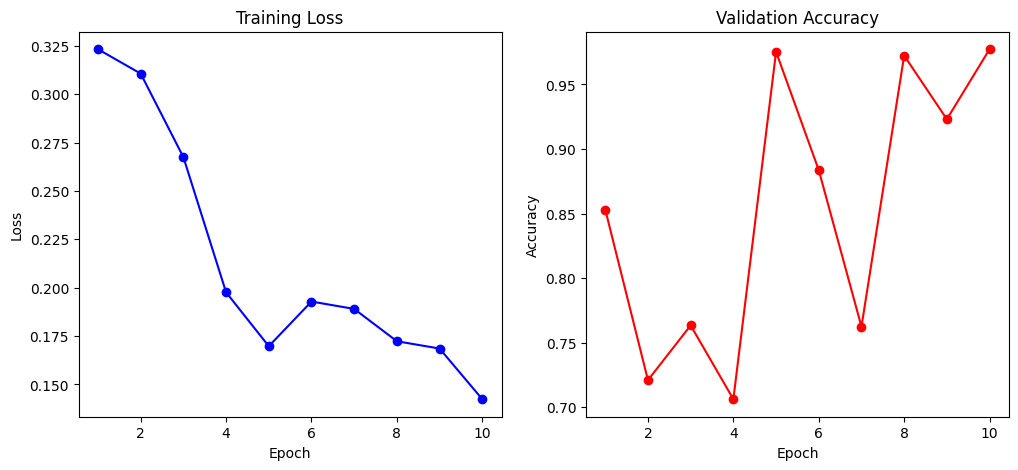

In [ ]:
# ✅
def plot_history(history):
    epochs = range(1, len(history["train_loss"]) + 1)

    plt.figure(figsize=(12,5))
    # train
    plt.subplot(1,2,1)
    plt.plot(epochs, history["train_loss"], 'b-o')
    plt.title("Training Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    # val
    plt.subplot(1,2,2)
    plt.plot(epochs, history["val_accuracy"], 'r-o')
    plt.title("Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")

    plt.show()
plot_history(history)

In [ ]:
# to be used with auxularity 
best_model.eval()
correct = 0
total = 0

pred = []
labels_list = []
with torch.no_grad():
    for images, labels in Test_B:
        images, labels = images.to(device), labels.to(device)
        outputs, _ = best_model(images)  # ignore auxiliary during evaluation
        predicted = torch.argmax(outputs, dim=1)
        pred.append(predicted)
        labels_list.append(labels)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()


y_pred = torch.cat(pred).cpu()
y_labels = torch.cat(labels_list).cpu()
test_acc = correct / total
print(f"Test Accuracy: {test_acc:.4f}")


ValueError: too many values to unpack (expected 2)

In [143]:
# ✅
best_model.eval()
correct = 0
total = 0

pred = []
labels_list = []
with torch.no_grad():
    for images, labels in Test_B:
        images, labels = images.to(device), labels.to(device)
        outputs = best_model(images)
        predicted = torch.max(outputs, 1)[1]
        pred.append(predicted)
        labels_list.append(labels)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()


y_pred = torch.cat(pred).cpu()
y_labels = torch.cat(labels_list).cpu()
test_acc = correct / total
print(f"Test Accuracy: {test_acc:.4f}")


Test Accuracy: 0.9663


In [144]:
from sklearn.metrics import confusion_matrix, classification_report

print("\nClassification report:\n")
print(classification_report(y_labels, y_pred, target_names=class_names, digits=4))


Classification report:

              precision    recall  f1-score   support

      cloudy     0.9600    0.9600    0.9600       150
       water     0.9859    0.9333    0.9589       150
  green_area     0.9375    1.0000    0.9677       150
      desert     0.9911    0.9737    0.9823       114

    accuracy                         0.9663       564
   macro avg     0.9686    0.9668    0.9672       564
weighted avg     0.9672    0.9663    0.9663       564



In [129]:
# ✅
torch.save(best_model.state_dict(), "model2.pth")

In [145]:
# ✅
def predict_random_image(model, img_paths, class_names, device):
    img_path = random.choice(img_paths)
    img = Image.open(img_path).convert("RGB")

    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    ])

    input_tensor = transform(img).unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        logits = model(input_tensor)
        probs = torch.softmax(logits, dim=1)
        predicted_idx = probs.argmax(dim=1).item()
        confidence = probs[0, predicted_idx].item()

    predicted_label = class_names[predicted_idx]

    #  PLOTTING HERE
    plt.figure(figsize=(4, 4))
    plt.imshow(img)
    plt.title(f"Predicted: {predicted_label}\nConfidence: {confidence:.2f}")
    plt.axis("off")
    plt.show()

    print(f"Image path: {img_path}")


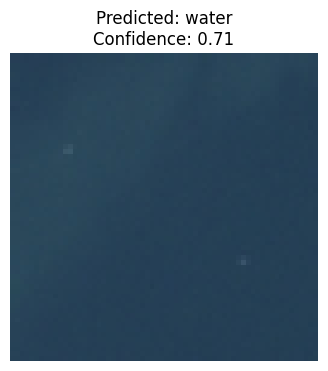

Image path: data/water/SeaLake_956.jpg


In [146]:
# ✅
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load model
model = CustomInception(num_classes=len(class_names)).to(device)
model.load_state_dict(torch.load("model2.pth", map_location=device))
model.eval()

predict_random_image(model, Test_paths, class_names, device)


In [ ]:
# try later :
# b) Learning rate scheduler
# CosineAnnealingLR or OneCycleLR can improve convergence.